In [29]:
import math
import pandas as pd
import numpy as np
import matplotlib as mpl
from windrose import WindroseAxes
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Input, Dropout
from ipywidgets import interact, Dropdown, IntSlider, Layout
import glob
import os
import plotly
import plotly.express as px
import plotly.graph_objects as go
from datetime import timedelta
%matplotlib inline
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# import plotly.io as pio
# pio.renderers.default = "notebook"
# plotly.offline.init_notebook_mode(connected=True)

# print("✅ Plotly 설정이 완료되었습니다!")

In [3]:
dir_path = '365_weather'
file_list = glob.glob(os.path.join(dir_path, '*.csv'))
df_list = []

for file_path in file_list:
    try:
        df = pd.read_csv(file_path, header=None)

        new_columns = []
        for col_name, unit in zip(df.iloc[1], df.iloc[2]):
            if pd.isna(unit) or unit == '-':
                new_columns.append(col_name)
            else:
                new_columns.append(f"{col_name} {unit}")

        df.columns = new_columns
        df_cleaned = df.iloc[7:].copy()

        if '일조시간 (hr:mm)' in df_cleaned.columns:
            df_cleaned = df_cleaned.drop('일조시간 (hr:mm)', axis=1)
        df_list.append(df_cleaned)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

if df_list:
    merged_df = pd.concat(df_list, ignore_index=True)
    
    print("✅ 모든 파일이 병합되고 데이터 정리가 완료되었습니다.")
    print("\n통합된 데이터프레임의 상위 5개 행:")
    print(merged_df.head())
    print("\n통합된 데이터프레임의 정보:")
    merged_df.info()

else:
    print("디렉터리 내에 csv 파일이 없습니다.")

✅ 모든 파일이 병합되고 데이터 정리가 완료되었습니다.

통합된 데이터프레임의 상위 5개 행:
   날짜 (년-월-일) 평균기온 ( ℃ ) 최고기온 ( ℃ ) 최저기온 ( ℃ ) 습도 ( % ) 풍향 (방향) 풍속 ( m/s )  \
0  2015-01-01       -6.6       -2.5      -12.1     47.1     서남서        2.2   
1  2015-01-02       -7.5       -0.2      -14.5     63.6     서남서        1.6   
2  2015-01-03       -7.6        2.7      -17.4     70.1      남서        0.7   
3  2015-01-04       -1.5        8.8       -7.2     77.9       남        0.5   
4  2015-01-05         -1        7.8       -8.5     82.5      남동        0.4   

  강수량 ( mm ) 일사량 ( MJ/㎡ ) 일조시간 ( hr:mm )  
0          0           10              -  
1          0          9.4              -  
2          0          9.9              -  
3          0          6.7              -  
4          1          6.7              -  

통합된 데이터프레임의 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3882 entries, 0 to 3881
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   날짜 

In [4]:
merged_df.to_csv('365_weather_cleaned.csv', index=False, encoding='utf-8-sig')
print("데이터프레임이 '365_weather_cleaned.csv' 파일로 성공적으로 저장되었습니다.")

데이터프레임이 '365_weather_cleaned.csv' 파일로 성공적으로 저장되었습니다.


In [5]:
weather_df_raw = merged_df.drop('일조시간 ( hr:mm )', axis=1)

In [6]:
weather_df = weather_df_raw.replace('-', np.nan)

In [7]:
weather_df = weather_df.dropna()
print(len(weather_df))

3867


In [8]:
weather_df['날짜 (년-월-일)'] = pd.to_datetime(weather_df['날짜 (년-월-일)'], format="%Y-%m-%d")

In [9]:
weather_df.max()

날짜 (년-월-일)      2025-08-20 00:00:00
평균기온 ( ℃ )                      9.9
최고기온 ( ℃ )                      9.9
최저기온 ( ℃ )                      9.9
습도 ( % )                       99.9
풍향 (방향)                         서남서
풍속 ( m/s )                      3.5
강수량 ( mm )                     94.5
일사량 ( MJ/㎡ )                    9.9
dtype: object

In [10]:
weather_df.min()

날짜 (년-월-일)      2015-01-01 00:00:00
평균기온 ( ℃ )                     -0.1
최고기온 ( ℃ )                     -0.1
최저기온 ( ℃ )                     -0.1
습도 ( % )                        100
풍향 (방향)                           남
풍속 ( m/s )                      0.1
강수량 ( mm )                        0
일사량 ( MJ/㎡ )                      0
dtype: object

In [11]:
numeric_cols = ['평균기온 ( ℃ )', '최고기온 ( ℃ )', '최저기온 ( ℃ )', '습도 ( % )',
                '풍속 ( m/s )', '강수량 ( mm )', '일사량 ( MJ/㎡ )']

for col in numeric_cols:
    weather_df[col] = pd.to_numeric(weather_df[col], errors='coerce')

In [12]:
weather_df['연도'] = weather_df['날짜 (년-월-일)'].dt.year
weather_df['월'] = weather_df['날짜 (년-월-일)'].dt.month

plot_columns = [
    '평균기온 ( ℃ )', '최고기온 ( ℃ )', '최저기온 ( ℃ )', '습도 ( % )',
    '풍속 ( m/s )', '강수량 ( mm )', '일사량 ( MJ/㎡ )'
]

In [13]:
def plot_daily_trend(feature, year):
    df_filtered = weather_df[weather_df['연도'] == year].copy()

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_filtered['날짜 (년-월-일)'], 
        y=df_filtered[feature], 
        mode='lines+markers', 
        name=f'{year}년'
    ))

    fig.update_layout(
        title=f'{year}년 일별 {feature} 변화 추세',
        xaxis_title='날짜',
        yaxis_title=feature,
        template='plotly_white',
        width = 1500,
        height = 600
    )
    fig.show()

In [14]:
def plot_daily_data(feature, year, month):
    df_filtered = weather_df[(weather_df['연도'] == year) & (weather_df['월'] == month)].copy()
    df_filtered['일'] = df_filtered['날짜 (년-월-일)'].dt.day

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_filtered['일'], 
        y=df_filtered[feature], 
        mode='lines+markers', 
        name=f'{year}년 {month}월'
    ))

    fig.update_layout(
        title=f'{year}년 {month}월 일별 {feature} 변화',
        xaxis_title='일',
        yaxis_title=feature,
        xaxis=dict(tickmode='array', tickvals=df_filtered['일']),
        template='plotly_white',
        width = 1500,
        height = 600
    )
    fig.show()

In [15]:
slider_layout = Layout(width='700px')

In [16]:
interact(plot_daily_trend, 
         feature=Dropdown(options=numeric_cols, description='지표 선택'),
         year=IntSlider(min=weather_df['연도'].min(), max=weather_df['연도'].max(), step=1, value=weather_df['연도'].min(), description='연도 선택', layout=slider_layout))

interactive(children=(Dropdown(description='지표 선택', options=('평균기온 ( ℃ )', '최고기온 ( ℃ )', '최저기온 ( ℃ )', '습도 ( %…

<function __main__.plot_daily_trend(feature, year)>

In [17]:
interact(plot_daily_data, 
         feature=Dropdown(options=plot_columns, description='지표 선택'),
         year=IntSlider(min=weather_df['연도'].min(), max=weather_df['연도'].max(), step=1, value=weather_df['연도'].min(), description='연도 선택', layout=slider_layout),
         month=IntSlider(min=1, max=12, step=1, value=1, description='월 선택', layout=slider_layout))

interactive(children=(Dropdown(description='지표 선택', options=('평균기온 ( ℃ )', '최고기온 ( ℃ )', '최저기온 ( ℃ )', '습도 ( %…

<function __main__.plot_daily_data(feature, year, month)>

In [18]:
weather_df['풍향 (방향)'].value_counts()

풍향 (방향)
서남서    1003
남서      695
남남서     491
동남동     449
남       342
동       316
남동      270
남남동     247
서        44
동북동      10
Name: count, dtype: int64

In [19]:
weather_df = weather_df[weather_df['풍향 (방향)'] != '-']

print("삭제 후 행의 개수:", len(weather_df))

삭제 후 행의 개수: 3867


In [20]:
unique_directions = weather_df['풍향 (방향)'].unique()
print(unique_directions)

['서남서' '남서' '남' '남동' '동남동' '남남동' '남남서' '동' '서' '동북동']


In [21]:
direction_mapping = {
    '북': 0, '북북동': 22.5, '북동': 45, '동북동': 67.5,
    '동': 90, '동남동': 112.5, '남동': 135, '남남동': 157.5,
    '남': 180, '남남서': 202.5, '남서': 225, '서남서': 247.5,
    '서': 270, '서북서': 292.5, '북서': 315, '북북서': 337.5,
}

weather_df['풍향 (방향)'] = weather_df['풍향 (방향)'].map(direction_mapping)
print(weather_df[['풍향 (방향)']].head())

   풍향 (방향)
0    247.5
1    247.5
2    225.0
3    180.0
4    135.0


In [22]:
def plot_windrose(year, month):
    
    df_filtered = weather_df[(weather_df['연도'] == year) & (weather_df['월'] == month)].copy()
    
    bins = pd.cut(df_filtered['풍속 ( m/s )'], bins=[0, 2, 4, 6, 8, np.inf], labels=['0-2', '2-4', '4-6', '6-8', '8+'])
    df_filtered['풍속 (분류)'] = bins

    bins_angles = np.arange(0, 360 + 22.5, 22.5)
    bins_labels = ['북', '북북동', '북동', '동북동', '동', '동남동', '남동', '남남동', '남', '남남서', '남서', '서남서', '서', '서북서', '북서', '북북서']
    df_filtered['풍향 (16방위)'] = pd.cut(df_filtered['풍향 (방향)'], bins=bins_angles, labels=bins_labels, right=False)

    windrose_data = df_filtered.groupby(['풍향 (16방위)', '풍속 (분류)'], observed=False).size().reset_index(name='빈도')

    fig = px.bar_polar(
        windrose_data,
        r='빈도',
        theta='풍향 (16방위)',
        color='풍속 (분류)',
        category_orders={"풍속 (분류)": ['0-2', '2-4', '4-6', '6-8', '8+'], "풍향 (16방위)": bins_labels},
        color_discrete_sequence=px.colors.sequential.Plasma_r,
        title=f'{year}년 {month}월 풍향/풍속 분포'
    )

    fig.update_layout(
        polar_radialaxis_ticks='inside',
        polar_angularaxis_direction="clockwise",
        width=1000,
        height=1000
    )

    fig.show()

In [23]:
interact(plot_windrose, 
         year=IntSlider(min=weather_df['연도'].min(), max=weather_df['연도'].max(), step=1, value=weather_df['연도'].min(), description='연도 선택', layout=slider_layout),
         month=IntSlider(min=1, max=12, step=1, value=1, description='월 선택', layout=slider_layout))

interactive(children=(IntSlider(value=2015, description='연도 선택', layout=Layout(width='700px'), max=2025, min=2…

<function __main__.plot_windrose(year, month)>

In [24]:
df_lstm = weather_df.drop(columns=['연도', '월'])

In [25]:
df_lstm['월'] = df_lstm['날짜 (년-월-일)'].dt.month
df_lstm['월_sin'] = np.sin(2 * np.pi * df_lstm['월'] / 12.0)
df_lstm['월_cos'] = np.cos(2 * np.pi * df_lstm['월'] / 12.0)

df_lstm['일'] = df_lstm['날짜 (년-월-일)'].dt.day
df_lstm['일수'] = df_lstm['날짜 (년-월-일)'].dt.daysinmonth
df_lstm['일_sin'] = np.sin(2 * np.pi * df_lstm['일'] / df_lstm['일수'])
df_lstm['일_cos'] = np.cos(2 * np.pi * df_lstm['일'] / df_lstm['일수'])

df_lstm['년'] = df_lstm['날짜 (년-월-일)'].dt.year

In [26]:
df_lstm = df_lstm.drop(columns = ['월', '일', '일수'])

In [27]:
data = df_lstm.drop(columns = ['날짜 (년-월-일)'])

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0975 - val_loss: 0.0337
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0281 - val_loss: 0.0251
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0236 - val_loss: 0.0238
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0219 - val_loss: 0.0223
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0208 - val_loss: 0.0222
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0206 - val_loss: 0.0225
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0206 - val_loss: 0.0228
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0205 - val_loss: 0.0225
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0204 - val_loss: 0.0224
Epoch 10/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0204 - val_loss: 0.0227
Epoch 11/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0203 - val_loss: 0.0226
Epoch 12/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0

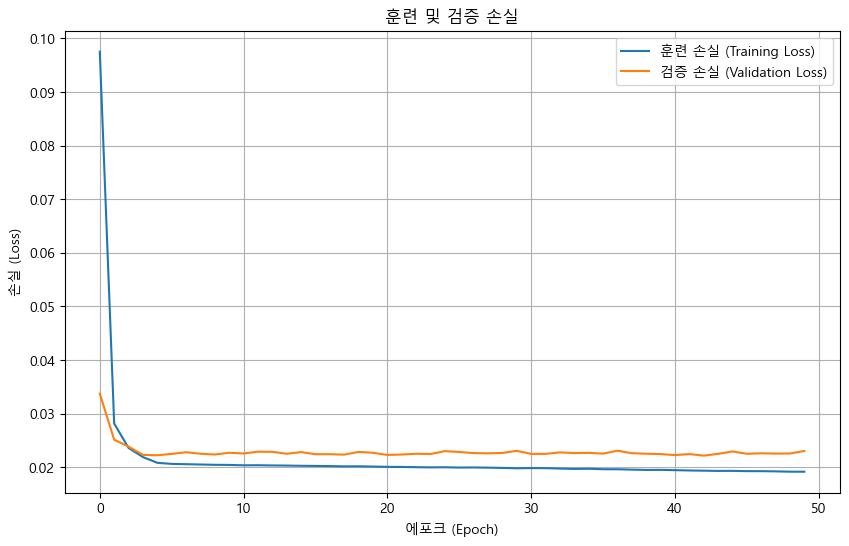

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step

예측 결과가 'lstm_pred_final.csv' 파일로 저장되었습니다.


In [28]:
input_features = ['평균기온 ( ℃ )', '최고기온 ( ℃ )', '최저기온 ( ℃ )', '습도 ( % )',
                  '풍향 (방향)', '풍속 ( m/s )', '강수량 ( mm )', '일사량 ( MJ/㎡ )',
                  '월_sin', '월_cos', '일_sin', '일_cos', '년']

output_features = ['평균기온 ( ℃ )', '최고기온 ( ℃ )', '최저기온 ( ℃ )', '습도 ( % )',
                   '풍향 (방향)', '풍속 ( m/s )', '강수량 ( mm )', '일사량 ( MJ/㎡ )']

scaler_input = MinMaxScaler(feature_range=(0, 1))
scaled_input_data = scaler_input.fit_transform(df_lstm[input_features])

scaler_output = MinMaxScaler(feature_range=(0, 1))
scaled_output_data = scaler_output.fit_transform(df_lstm[output_features])

def create_sequences(input_data, output_data, n_steps, n_future):
    X, y = [], []
    for i in range(len(input_data) - n_steps - n_future + 1):
        seq_x = input_data[i:(i + n_steps)]
        seq_y = output_data[(i + n_steps):(i + n_steps + n_future)]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 90
n_future = 30

X, y = create_sequences(scaled_input_data, scaled_output_data, n_steps, n_future)

split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, y_train = X[:split_index], y[:split_index]
X_val, y_val = X[split_index:], y[split_index:]

num_features_input = X.shape[2]
num_features_output = y.shape[2]

model = Sequential()
model.add(Input(shape=(n_steps, num_features_input)))
model.add(LSTM(25, activation='tanh', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(25, activation='tanh'))
model.add(Dense(n_future * num_features_output, activation='linear'))
model.add(Reshape((n_future, num_features_output)))

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=50, verbose=1, 
                    validation_data=(X_val, y_val))

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='훈련 손실 (Training Loss)')
plt.plot(history.history['val_loss'], label='검증 손실 (Validation Loss)')
plt.title('훈련 및 검증 손실')
plt.xlabel('에포크 (Epoch)')
plt.ylabel('손실 (Loss)')
plt.legend()
plt.grid(True)
plt.show()

last_sequence = X_val[-1:]
predicted_values = model.predict(last_sequence)

predicted_original_scale = scaler_output.inverse_transform(predicted_values.reshape(-1, num_features_output))
predicted_original_scale = predicted_original_scale.reshape(n_future, num_features_output)

last_date = weather_df['날짜 (년-월-일)'].iloc[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, n_future + 1)]

predicted_df = pd.DataFrame(predicted_original_scale, columns=output_features)
predicted_df['날짜 (년-월-일)'] = future_dates
predicted_df['월_sin'] = np.sin(2 * np.pi * predicted_df['날짜 (년-월-일)'].dt.month / 12.0)
predicted_df['월_cos'] = np.cos(2 * np.pi * predicted_df['날짜 (년-월-일)'].dt.month / 12.0)
predicted_df['일_sin'] = np.sin(2 * np.pi * predicted_df['날짜 (년-월-일)'].dt.day / predicted_df['날짜 (년-월-일)'].dt.daysinmonth)
predicted_df['일_cos'] = np.cos(2 * np.pi * predicted_df['날짜 (년-월-일)'].dt.day / predicted_df['날짜 (년-월-일)'].dt.daysinmonth)

predicted_df.to_csv('lstm_pred_final.csv', encoding='utf-8-sig', index=False)
print("\n예측 결과가 'lstm_pred_final.csv' 파일로 저장되었습니다.")